<a id=0></a>
# Прогнозирование оттока клиентов для телеком компании

[Содержание](#0)

[1. Описание проекта](#1)

[2. Исследовательский анализ данных](#2)

[3. Анализ данных и подготовка признаков](#3)

[4. Обучение моделей](#4)

[5. Тестирование лучшей модели](#5)

[6. Общий вывод](#6)

[7. Отчет](#7)


<a id=1></a>
## 1. Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Цель проекта:**

Провести исследование и подготовить модель машинного обучения, которая поможет прогнозировать отток клиентов.

Если модель покажет, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

Значение метрики AUC-ROC должно быть не ниже 0.85.

**Описание услуг:**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Данные:**

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**Признаки:**

Таблица `contract_new`:

- `BeginDate` - дата начала пользования услугами
- `EndDate` - дата окончания пользования услугами
- `Type` - тип оплаты: ежемесячный, годовой и т.д.
- `PaperlessBilling` - электронный платёжный документ
- `PaymentMethod` - способ оплаты
- `MonthlyCharges` - ежемесячные траты на услуги
- `TotalCharges` - всего потрачено денег на услуги

Таблица `personal_new`:

- `gender` - пол
- `SeniorCitizen` - наличие пенсионного статуса по возрасту
- `Partner` - наличие супруга(и)
- `Dependents` - наличие иждивенцев


Таблица `internet_new`:

- `InternetService` - тип подключения интернета ('DSL' или 'Fiber optic')
- `OnlineSecurity` - блокировка небезопасных сайтов
- `OnlineBackup` - облачное хранилище файлов для резервного копирования данных
- `DeviceProtection` - антивирус
- `TechSupport` - выделенная линия технической поддержки
- `StreamingTV` - стриминговое телевидение
- `StreamingMovies` - каталог фильмов

Таблица `phone_new`:

- `MultipleLines` - наличие возможности ведения параллельных линий во время звонка

**План работы:**

- Загрузить и изучить данные. Размеры датафреймов. Наличие пропусков и дубликатов. Гистограммы по численным столбцам.

- Заполнить пропущенные значения и обработать аномалии в столбцах.  Возможно потребуется объединить данные из разных таблиц. Проверить признаки на мультиколлинеарность. Если среди признаков имеются неинформативные, удалить их.

- Подготовить выборки для обучения моделей. Проверка на дисбаланс классов.

- Выбрать подходящие модели. Разбить данные на обучающие и тестовые. Обучить несколько разных моделей. Для каждой модели подобрать гиперпараметры.

- Проанализировать время обучения, время предсказания и качество моделей по целевым метрикам ROC-AUC и Accuracy.

- Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

- Проанализировать полученный результат, посмотреть влияние признаков.

- Сделать выводы, оформить проект.


<a id=2></a>
[Содержание](#0)
## 2. Исследовательский анализ данных

In [1]:
!pip install phik

In [2]:
import pandas as pd
import numpy as np
import random
import time
import phik
from phik.report import plot_correlation_matrix
from sklearn.model_selection import cross_validate, GridSearchCV, KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

RND_STATE = 15052023

In [3]:
def show_unic(df):
    for column in df.columns:
        print('\nСтолбец:', column)
        print('Уникальных значений:', len(df[column].unique()))
        print(df[column].value_counts())
        print(50*'-')

**2.1. Загрузка данных**

Загрузим информация о договорах из файла `contract_new.csv` в датафрейм:

In [4]:
try:
    contract_df = pd.read_csv('/datasets/contract_new.csv')
except:
    contract_df = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')

display(contract_df.info())
display(contract_df.sample(5))
display(contract_df.describe(include = 'all'))
print('Дубликатов:', contract_df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1523,9327-QSDED,2019-06-01,No,Month-to-month,No,Mailed check,43.55,372.79
4177,3470-BTGQO,2018-05-01,No,Month-to-month,No,Mailed check,45.65,1035.34
2580,7748-UMTRK,2017-08-01,No,Month-to-month,Yes,Electronic check,101.30,3039.0
2298,6670-MFRPK,2014-05-01,No,Two year,Yes,Credit card (automatic),79.20,5847.34
5661,4396-KLSEH,2019-10-01,No,Month-to-month,Yes,Electronic check,19.85,79.4


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,3506-LCJDC,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


Дубликатов: 0


Явных пропусков данных и дубликатов нет.

In [5]:
show_unic(contract_df)


Столбец: customerID
Уникальных значений: 7043
3506-LCJDC    1
1848-LBZHY    1
6124-ACRHJ    1
9079-YEXQJ    1
7880-XSOJX    1
             ..
7240-ETPTR    1
9894-EZEWG    1
6005-OBZPH    1
8849-AYPTR    1
9866-QEVEE    1
Name: customerID, Length: 7043, dtype: int64
--------------------------------------------------

Столбец: BeginDate
Уникальных значений: 77
2014-02-01    366
2019-09-01    237
2019-10-01    237
2019-11-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-12-01      3
2013-10-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64
--------------------------------------------------

Столбец: EndDate
Уникальных значений: 67
No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2015-04-01       2
2014-09-01       2
2014-06-01       1
2014-11-01       1
2014-10-01       1
Name: EndDate, Length: 67, dtype: int64
--------------------------------------------------

Сто

Только признак `MonthlyCharges` имеет числовой тип данных, остальные признаки имеют тип данных object.

Все значения `customerID` - уникальны.

Загрузим персональные данные клиентов из файла `personal_new.csv` в датафрейм:

In [6]:
try:
    personal_df = pd.read_csv('/datasets/personal_new.csv')
except:
    personal_df = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')

display(personal_df.info())
display(personal_df.sample(5))
display(personal_df.describe(include = 'all'))
print('Дубликатов:', personal_df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
3695,6088-BXMRG,Female,0,Yes,Yes
3331,7644-OMVMY,Male,0,Yes,Yes
5799,8066-POXGX,Female,0,No,No
1540,2796-UUZZO,Male,0,Yes,Yes
5414,2722-VOJQL,Male,0,No,No


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,3506-LCJDC,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


Дубликатов: 0


Явных пропусков данных и дубликатов нет.

In [7]:
show_unic(personal_df)


Столбец: customerID
Уникальных значений: 7043
3506-LCJDC    1
1848-LBZHY    1
6124-ACRHJ    1
9079-YEXQJ    1
7880-XSOJX    1
             ..
7240-ETPTR    1
9894-EZEWG    1
6005-OBZPH    1
8849-AYPTR    1
9866-QEVEE    1
Name: customerID, Length: 7043, dtype: int64
--------------------------------------------------

Столбец: gender
Уникальных значений: 2
Male      3555
Female    3488
Name: gender, dtype: int64
--------------------------------------------------

Столбец: SeniorCitizen
Уникальных значений: 2
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
--------------------------------------------------

Столбец: Partner
Уникальных значений: 2
No     3641
Yes    3402
Name: Partner, dtype: int64
--------------------------------------------------

Столбец: Dependents
Уникальных значений: 2
No     4933
Yes    2110
Name: Dependents, dtype: int64
--------------------------------------------------


Только признак `SeniorCitizen` имеет числовой тип данных, остальные признаки имеют тип данных object.

Все значения `customerID` - уникальны.

Загрузим информация об интернет-услугах из файла `internet_new.csv` в датафрейм:

In [8]:
try:
    internet_df = pd.read_csv('/datasets/internet_new.csv')
except:
    internet_df = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')

display(internet_df.info())
display(internet_df.sample(5))
display(internet_df.describe(include = 'all'))
print('Дубликатов:', internet_df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4323,0623-GDISB,DSL,Yes,No,No,No,No,No
1889,5136-KCKGI,Fiber optic,Yes,No,Yes,No,Yes,Yes
1334,6839-ITVZJ,DSL,No,Yes,No,Yes,No,No
3346,8189-XRIKE,Fiber optic,No,No,No,No,Yes,Yes
3264,1194-BHJYC,DSL,Yes,No,Yes,Yes,Yes,Yes


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,6235-VDHOM,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Дубликатов: 0


Явных пропусков данных и дубликатов нет.

In [9]:
show_unic(internet_df)


Столбец: customerID
Уникальных значений: 5517
6235-VDHOM    1
8169-SAEJD    1
8350-NYMVI    1
1032-MAELW    1
3104-OWCGK    1
             ..
1932-UEDCX    1
4482-EWFMI    1
9489-UTFKA    1
0661-KBKPA    1
9866-QEVEE    1
Name: customerID, Length: 5517, dtype: int64
--------------------------------------------------

Столбец: InternetService
Уникальных значений: 2
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64
--------------------------------------------------

Столбец: OnlineSecurity
Уникальных значений: 2
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64
--------------------------------------------------

Столбец: OnlineBackup
Уникальных значений: 2
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64
--------------------------------------------------

Столбец: DeviceProtection
Уникальных значений: 2
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64
--------------------------------------------------

Столбец: TechSupport
Уникальны

Все признаки имеют тип данных `object`.

Все значения `customerID` - уникальны.

Загрузим информация об услугах телефонии из файла `contract_new.csv` в датафрейм:

In [10]:
try:
    phone_df = pd.read_csv('/datasets/phone_new.csv')
except:
    phone_df = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

display(phone_df.info())
display(phone_df.sample(5))
display(phone_df.describe(include = 'all'))
print('Дубликатов:', phone_df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
4438,2305-MRGLV,No
3021,1640-PLFMP,No
4060,9541-ZPSEA,No
1836,7328-OWMOM,No
2088,9578-VRMNM,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,3506-LCJDC,No
freq,1,3390


Дубликатов: 0


Явных пропусков данных и дубликатов нет.

In [11]:
show_unic(phone_df)


Столбец: customerID
Уникальных значений: 6361
3506-LCJDC    1
6475-VHUIZ    1
5193-QLVZB    1
9327-QSDED    1
3338-CVVEH    1
             ..
8203-XJZRC    1
9300-RENDD    1
2931-XIQBR    1
9739-JLPQJ    1
9866-QEVEE    1
Name: customerID, Length: 6361, dtype: int64
--------------------------------------------------

Столбец: MultipleLines
Уникальных значений: 2
No     3390
Yes    2971
Name: MultipleLines, dtype: int64
--------------------------------------------------


Все признаки имеют тип данных object.

Все значения `customerID` - уникальны.

**Вывод:**

- Во всех четырёх таблицах отсутствуют явные пропуски и дубликаты.
- В каждой из четырёх проанализированных таблиц все значения признака `customerID` - уникальны. Можно объединенить выбороки по этому признаку с использованием метода merge().
- Таблицы имеют разные размеры, после объединения появятся пропуски у клиентов, которые пользуются только одной из услуг (интернет/телефон).

**2.2. Объединение выборок**

Объединим все 4 загруженных датафрейма в один датафрейм data_df по признаку `customerID` так, чтобы данные не потерялись.

In [12]:
big_df = contract_df.merge(personal_df, how = 'outer', on = 'customerID')\
                     .merge(internet_df, how = 'outer', on = 'customerID')\
                     .merge(phone_df, how = 'outer', on = 'customerID')\
                     .reset_index(drop = True)
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Все 20 столбцов и 7043 строк сохранились в одном датасете.

В качестве идентификатора клиента можно использовать признак `customerID`, т к все его значения - уникальны.

Сделаем признак `customerID` индексом:

In [13]:
big_df.set_index('customerID', inplace = True)
big_df.columns

Index(['BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines'],
      dtype='object')

Переименуем признаки в соответствии с PEP8:

In [14]:
big_df.columns = ['begin_date',
                  'end_date',
                  'type',
                  'paperless_billing',
                  'payment_method',
                  'monthly_charges',
                  'total_charges',
                  'gender',
                  'senior_citizen',
                  'partner',
                  'dependents',
                  'internet_service',
                  'online_security',
                  'online_backup',
                  'device_protection',
                  'tech_support',
                  'streaming_tv',
                  'streaming_movies',
                  'multiple_lines']

big_df.columns = big_df.columns.str.lower()

In [15]:
big_df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


**2.3. Заполнение пропусков**

In [16]:
big_df.isna().sum()

begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Одинаковое количество пропусков во всех признаках выборки internet говорит о том, что 1526 клиентов не пользуются интернет-услугами.

Соответвенно 682 клиента не пользуются услугами телефонии. 

Заменим эти пропуски значением "No":

In [17]:
big_df = big_df.fillna('No')
big_df.isna().sum()

begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

**2.4. Преобразование типов**

Мы видим, что значение 'No' в признаке `end_date` подразумевает, что договор пользования услугами на момент выгрузки данных ещё действует. Для удобства заменим значение 'No' на дату выгрузки данных 1 февраля 2020 года:

In [18]:
big_df.loc[big_df['end_date'] == 'No', 'end_date'] = '2020-02-01 00:00:00'

Преобразуем строковые признаки `begin_date` и `end_date` в тип datetime64:

In [19]:
big_df['begin_date'] = pd.to_datetime(big_df['begin_date'], format='%Y-%m-%dT%H:%M:%S')
big_df['end_date'] = pd.to_datetime(big_df['end_date'], format='%Y-%m-%dT%H:%M:%S')

Преобразуем строковый признак `total_charges` в float64, т к это количественный признак:

In [20]:
big_df['total_charges'] = pd.to_numeric(big_df['total_charges'], errors = 'coerce')
print(big_df['total_charges'].dtypes)

float64


В признаке `total_charges` после преобразования типа появились 11 пропусков, посмотрим их:

In [21]:
big_df[big_df['total_charges'].isna()]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,No,No,No,No,No,No,No,No
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,No,No,No,No,No,No,No,No
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,No,No,No,No,No,No,No,No
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,No,No,No,No,No,No,No,No


Признак `end_date` для этих строк равен '2020-02-01', это значение ранее было установлено для действующих договоров клиентов.

Т к этих строк мало и они не несут информации об ушедших клиентах, их можно было бы удалить.

Другой вариант - вычислить значение признака `total_charges` по признакам `monthly_charges` и `type`, помножив ежемесячный платеж на срок договора в месяцах:

In [22]:
big_df.loc[(big_df['total_charges'].isna()) & (big_df['type'] == 'Two year'),
                'total_charges'] = big_df['monthly_charges'] * 24
big_df.loc[(big_df['total_charges'].isna()) & (big_df['type'] == 'One year'), 
                'total_charges'] = big_df['monthly_charges'] * 12

big_df.isna().sum().sum()

0

Признаки `paperless_billing`, `Partner`, `Dependents`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies` и `MultipleLines` принимают только два значения ('No'/'Yes'), т е это - категориальные признаки (бинарный классификатор).

Приведем их к типу int со значениями '0' и '1'.

Признак `gender` тоже категориальный, но мы его оставим как есть, т к невозможно однозначно опеределить новое название такого признака с типом int:

In [23]:
big_df.loc[big_df['paperless_billing'] == 'Yes', 'paperless_billing'] = 1
big_df.loc[big_df['paperless_billing'] == 'No', 'paperless_billing'] = 0
big_df['paperless_billing'] = big_df['paperless_billing'].astype('int')
print(big_df['paperless_billing'].dtypes)

int64


In [24]:
big_df.loc[big_df['partner'] == 'Yes', 'partner'] = 1
big_df.loc[big_df['partner'] == 'No', 'partner'] = 0
big_df['partner'] = big_df['partner'].astype('int')

In [25]:
big_df.loc[big_df['dependents'] == 'Yes', 'dependents'] = 1
big_df.loc[big_df['dependents'] == 'No', 'dependents'] = 0
big_df['dependents'] = big_df['dependents'].astype('int')

In [26]:
big_df.loc[big_df['online_security'] == 'Yes', 'online_security'] = 1
big_df.loc[big_df['online_security'] == 'No', 'online_security'] = 0
big_df['online_security'] = big_df['online_security'].astype('int')

In [27]:
big_df.loc[big_df['online_backup'] == 'Yes', 'online_backup'] = 1
big_df.loc[big_df['online_backup'] == 'No', 'online_backup'] = 0
big_df['online_backup'] = big_df['online_backup'].astype('int')

In [28]:
big_df.loc[big_df['device_protection'] == 'Yes', 'device_protection'] = 1
big_df.loc[big_df['device_protection'] == 'No', 'device_protection'] = 0
big_df['device_protection'] = big_df['device_protection'].astype('int')

In [29]:
big_df.loc[big_df['tech_support'] == 'Yes', 'tech_support'] = 1
big_df.loc[big_df['tech_support'] == 'No', 'tech_support'] = 0
big_df['tech_support'] = big_df['tech_support'].astype('int')

In [30]:
big_df.loc[big_df['streaming_tv'] == 'Yes', 'streaming_tv'] = 1
big_df.loc[big_df['streaming_tv'] == 'No', 'streaming_tv'] = 0
big_df['streaming_tv'] = big_df['streaming_tv'].astype('int')

In [31]:
big_df.loc[big_df['streaming_movies'] == 'Yes', 'streaming_movies'] = 1
big_df.loc[big_df['streaming_movies'] == 'No', 'streaming_movies'] = 0
big_df['streaming_movies'] = big_df['streaming_movies'].astype('int')

In [32]:
big_df.loc[big_df['multiple_lines'] == 'Yes', 'multiple_lines'] = 1
big_df.loc[big_df['multiple_lines'] == 'No', 'multiple_lines'] = 0
big_df['multiple_lines'] = big_df['multiple_lines'].astype('int')

big_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   int64         
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   int64         
 10  dependents         7043 non-null   int64         
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   int64         
 13  online_backup      7043 non-null   int64         
 14

**2.5. Преобразование признаков**

Добавим в датасет категориальный целевой признак - `out`, который принимает значения '1' (клиент ушёл) и '0' (клиент остался).

За основу возьмем произнак `end_date`, если дата указана, значит клиент ушел, признак `out` = 1:

In [33]:
big_df['out'] = 0
big_df.loc[big_df['end_date'] != '2020-02-01 00:00:00', 'out'] = 1
big_df['out'] = big_df['out'].astype('int')
print(big_df['out'].value_counts())

0    5942
1    1101
Name: out, dtype: int64


Для удобства работы с датами добавим в датасет новый признак `duration` - длительность договора в днях и сохраним его в тип int:

In [34]:
big_df['duration'] = big_df['end_date'] - big_df['begin_date']
big_df['duration'] = pd.to_numeric(big_df['duration'].dt.days, downcast = 'integer').astype(float)
big_df['duration'].head()

customerID
7590-VHVEG      31.0
5575-GNVDE    1036.0
3668-QPYBK     123.0
7795-CFOCW    1371.0
9237-HQITU     153.0
Name: duration, dtype: float64

Сохраним все численные признаки в переменную num, категориальные признаки в cat:

In [35]:
num = list(big_df.loc[:, big_df.dtypes == 'float'].columns.values)
num

['monthly_charges', 'total_charges', 'duration']

In [36]:
cat = list(big_df.loc[:, big_df.dtypes == 'object'].columns.values)\
    + list(big_df.loc[:, big_df.dtypes == 'int'].columns.values)
cat

['type',
 'payment_method',
 'gender',
 'internet_service',
 'paperless_billing',
 'senior_citizen',
 'partner',
 'dependents',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines',
 'out']

In [37]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   int64         
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   int64         
 10  dependents         7043 non-null   int64         
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   int64         
 13  online_backup      7043 non-null   int64         
 14

**2.6. Исследование численных признаков**

Посмотрим на гистограммах распределение численных признаков в датасете:

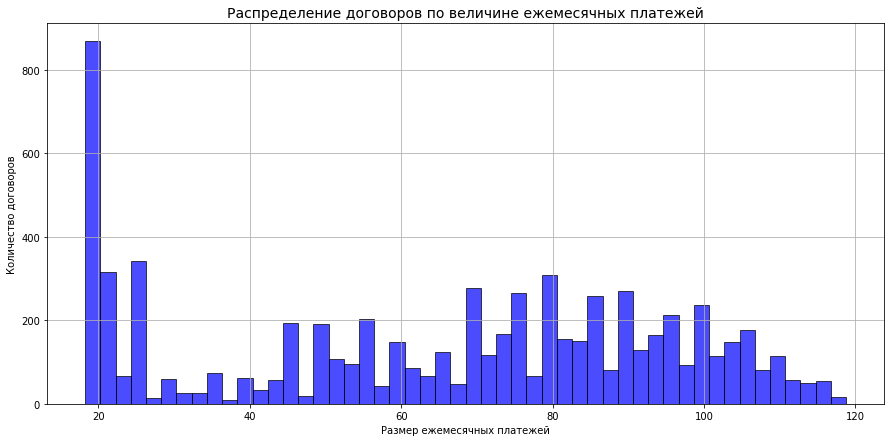

In [38]:
big_df['monthly_charges'].hist(figsize = (15, 7), bins = 50, alpha = 0.7, color = 'blue',\
                         edgecolor = 'black')
plt.xlabel('Размер ежемесячных платежей')
plt.ylabel('Количество договоров')
plt.title('Распределение договоров по величине ежемесячных платежей', fontsize = 14)
plt.show()

По признаку `monthly_charges` видно, что у компании большое кол-во небольших платежей за услуги (около 20р) и равномерное распределение остальных платежей (с пиком около 80р).

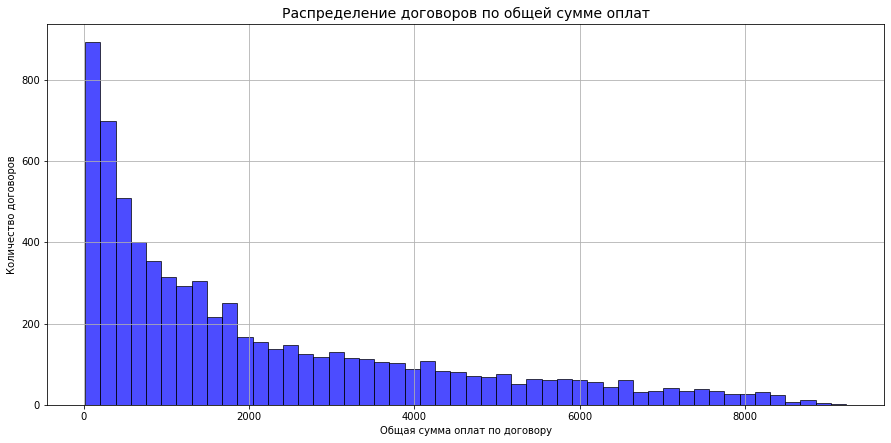

In [39]:
big_df['total_charges'].hist(figsize = (15, 7), bins = 50, alpha = 0.7, color = 'blue',\
                       edgecolor = 'black')
plt.xlabel('Общая сумма оплат по договору')
plt.ylabel('Количество договоров')
plt.title('Распределение договоров по общей сумме оплат', fontsize = 14)
plt.show()

На графике по признаку `total_charges` видно, что у компании много новых клиентов с ежмесячной оплатой за услуги, но есть и пул старых клиентов, заплативших суммарно более 4000р.

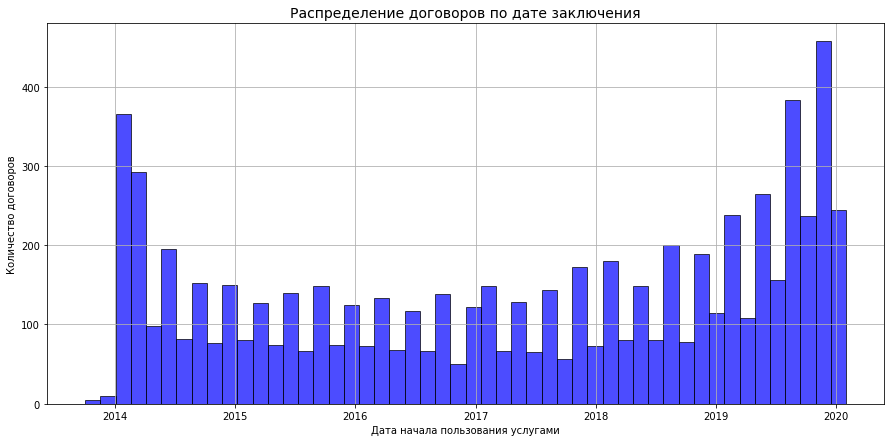

In [40]:
big_df['begin_date'].hist(figsize = (15, 7), bins = 50, alpha = 0.7, color = 'blue',\
                       edgecolor = 'black')
plt.xlabel('Дата начала пользования услугами')
plt.ylabel('Количество договоров')
plt.title('Распределение договоров по дате заключения', fontsize = 14)
plt.show()

На графике по признаку `begin_date` видно, что у компании были не лучшие времена с 2014 по 2017гг и кол-во новых клиентов сокращалось, но с 2018г кол-во клиентов растет, видимо проводятся рекламные компании.

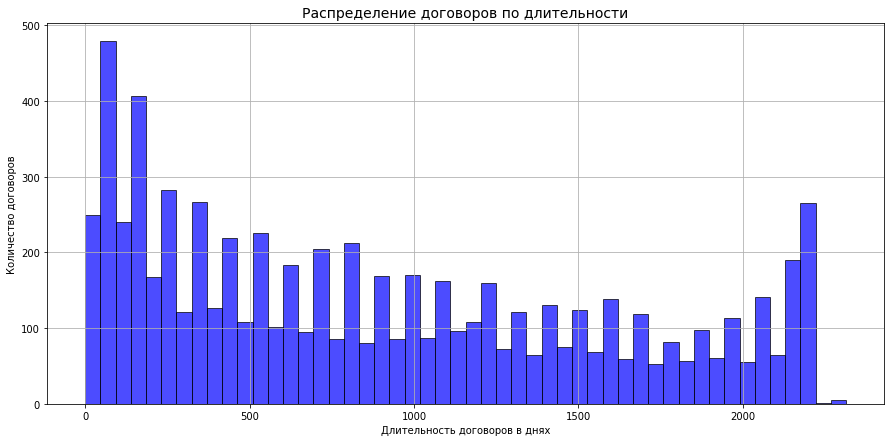

In [41]:
big_df['duration'].hist(figsize = (15, 7), bins = 50, alpha = 0.7, color = 'blue',\
                       edgecolor = 'black')
plt.xlabel('Длительность договоров в днях')
plt.ylabel('Количество договоров')
plt.title('Распределение договоров по длительности', fontsize = 14)
plt.show()

График по признаку `duration` показывает, то у компании много новых клиентов, но есть и пул старых клиентов.

График очень похож на график по признаку `begin_date`.

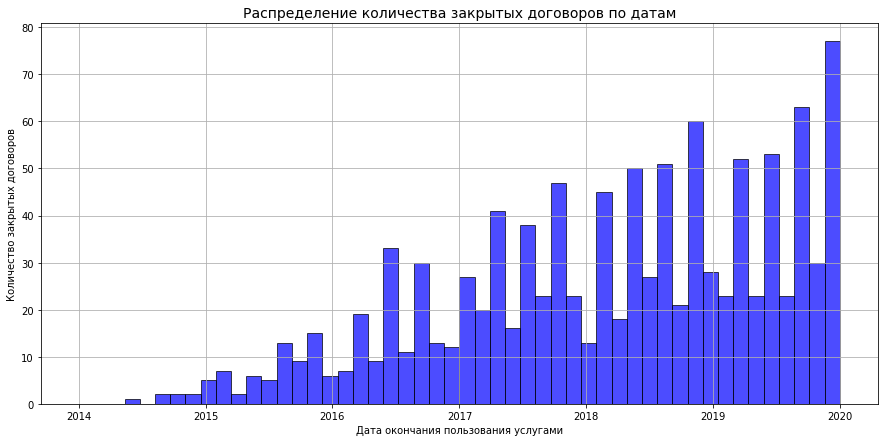

In [42]:
big_df['end_date'].hist(figsize = (15, 7), bins = 50, alpha = 0.7, color = 'blue',\
                       edgecolor = 'black', range = ['2014-01-01', '2020-01-01'])
plt.xlabel('Дата окончания пользования услугами')
plt.ylabel('Количество закрытых договоров')
plt.title('Распределение количества закрытых договоров по датам', fontsize = 14)
plt.show()

График по признаку `end_date` построенный без данных на '01-02-2020' показывает рост кол-ва уходящих клиентов.

Становится очевидным причина, по которой компания ищет возможность использовать модели ИИ для удержания клиентов.

**Вывод:**
- По признаку `begin_date` видно, что у компании были не лучшие времена с 2014 по 2017гг и кол-во новых клиентов сокращалось, но с 2018г кол-во клиентов растет, видимо проводятся рекламные компании.
- По признаку `end_date`, построенному без данных на '01-02-2020', виден рост кол-ва уходящих клиентов.
- По признакам `duration` и `total_charges` можно увидеть, что у компании много новых клиентов, но есть и пул старых клиентов.

**2.7. Проверка на мультиколлинеарность**

Для численных признаков используем корреляцию Пирсона/Спирмена.

Построим тепловую карту (хитмэп) корреляций Пирсона:

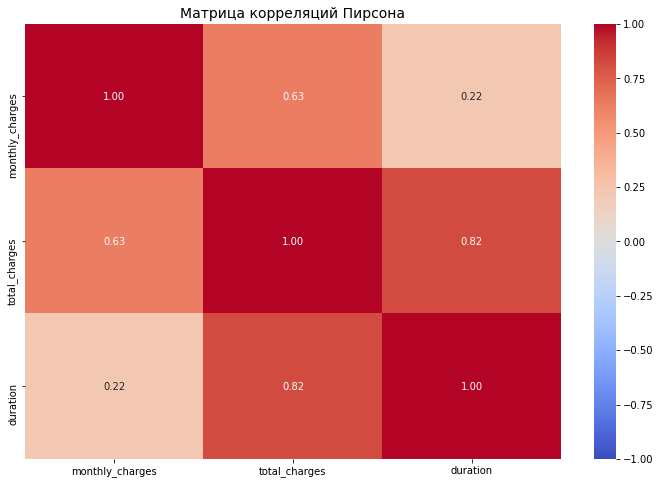

In [43]:
plt.figure(figsize = (12, 8))
sns.heatmap(big_df[num].corr(),\
    annot = True, fmt = '.2f', vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm')
plt.title('Матрица корреляций Пирсона', fontsize = 14)
plt.show()

Видим сильную корреляцию между признаками `total_charges` и `duration` - 0.82.

**2.8. Исследование категориальных признаков**

Посмотрим состав категориальных признаков, включая целевой признак:

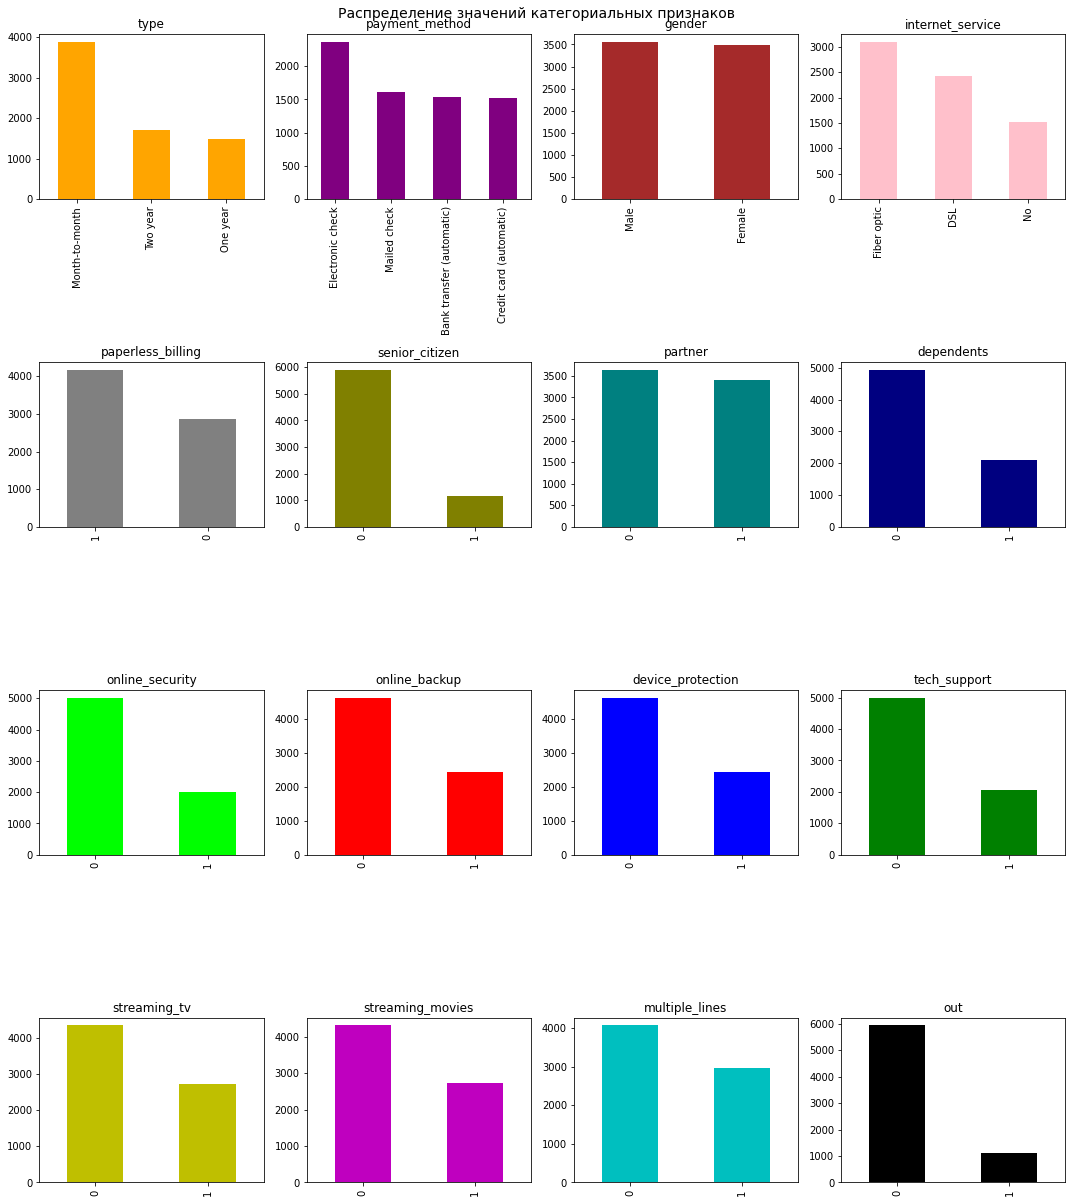

In [44]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (15, 17))

fig.suptitle('Распределение значений категориальных признаков', fontsize = 14)

axes = axs.ravel()
colors = ['orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'teal',\
          'navy', 'lime', 'r', 'b', 'g', 'y', 'm', 'c', 'k']

for i, column in enumerate(cat):
    big_df[column].value_counts().plot(kind = 'bar', ax = axes[i], color = colors[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

У большинства признаков наблюдается небольшой перекос классов.

Нет преобладания классов у признаков: `gender`(пол) и `partner`(наличие супруга).

Посмотрим соотношение классов по каждому признаку в процентах:

In [45]:
for column in cat:
    print(round(big_df.groupby(column).size() / len(big_df) * 100, 1))
    print(25*'-')

type
Month-to-month    55.0
One year          20.9
Two year          24.1
dtype: float64
-------------------------
payment_method
Bank transfer (automatic)    21.9
Credit card (automatic)      21.6
Electronic check             33.6
Mailed check                 22.9
dtype: float64
-------------------------
gender
Female    49.5
Male      50.5
dtype: float64
-------------------------
internet_service
DSL            34.4
Fiber optic    44.0
No             21.7
dtype: float64
-------------------------
paperless_billing
0    40.8
1    59.2
dtype: float64
-------------------------
senior_citizen
0    83.8
1    16.2
dtype: float64
-------------------------
partner
0    51.7
1    48.3
dtype: float64
-------------------------
dependents
0    70.0
1    30.0
dtype: float64
-------------------------
online_security
0    71.3
1    28.7
dtype: float64
-------------------------
online_backup
0    65.5
1    34.5
dtype: float64
-------------------------
device_protection
0    65.6
1    34.4
dtype: floa

Посмотрим распределение целевого признака `out`:

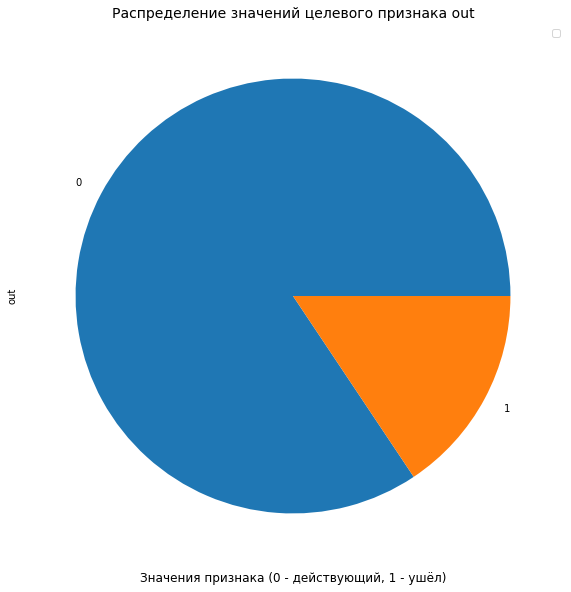

In [46]:
big_df['out'].value_counts().plot(kind = 'pie', figsize = (10, 10))

plt.xlabel('Значения признака (0 - действующий, 1 - ушёл)', fontsize = 12)
plt.title('Распределение значений целевого признака out', fontsize = 14)
plt.legend('')
plt.show()

In [47]:
print(round(big_df.groupby('out').size() / len(big_df) * 100, 1))

out
0    84.4
1    15.6
dtype: float64


**Вывод:**

Наибольший дисбалланс классов наблюдаем у целевого признака `out`: 84% (действующие клиенты) к 16% (ушедшие).

Для обучения моделей будем использовать кросс-валидацию, по этому из-за риска утечки данных апсемплинг (увеличение количества значений в классе) использовать нельзя.

В качестве метрики мы будем использовать AUC-ROC, которая не чувствительна к дисбалансу классов.

**2.9. Проверка на мультиколлинеарность**

Построим phi_k-корреляцию для всех признаков - численных и категориальных:

interval columns not set, guessing: ['paperless_billing', 'monthly_charges', 'total_charges', 'senior_citizen', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'out', 'duration']


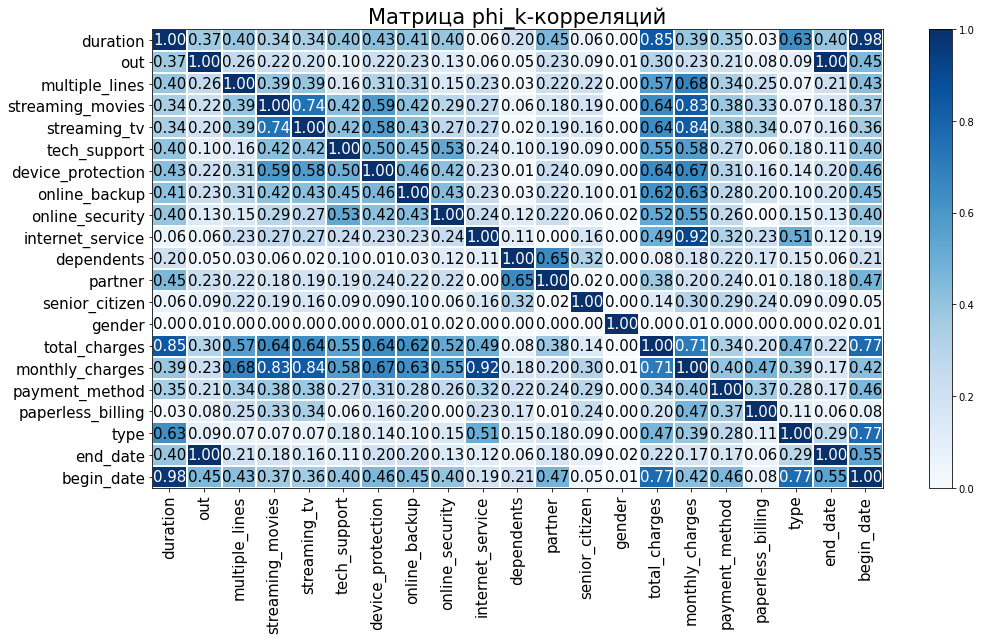

In [48]:
corr_matrix = big_df.phik_matrix()
plot_correlation_matrix(corr_matrix.values, 
                        x_labels = corr_matrix.columns, 
                        y_labels = corr_matrix.index, 
                        vmin = 0, vmax = 1, color_map = 'Blues', 
                        title = 'Матрица phi_k-корреляций',
                        fontsize_factor = 1.5, 
                        figsize = (15, 9))
plt.tight_layout()
plt.show()

Матрица показывает, что у признака `duration` имеется высокая корреляция с признаками `total_charges` (0.85) и `begin_date` (0.98), у признака `monthly_charges` с `streaming_tv` (0.83), `streaming_movies` (0.84) и `internet_service` (0.92).

Корреляция между признаками `end_date` и `out` равна '1', т к `out` построен прямым преобразованием `end_date`.

Построим парные графики корреляций численных признаков с целевым признаком `out`:

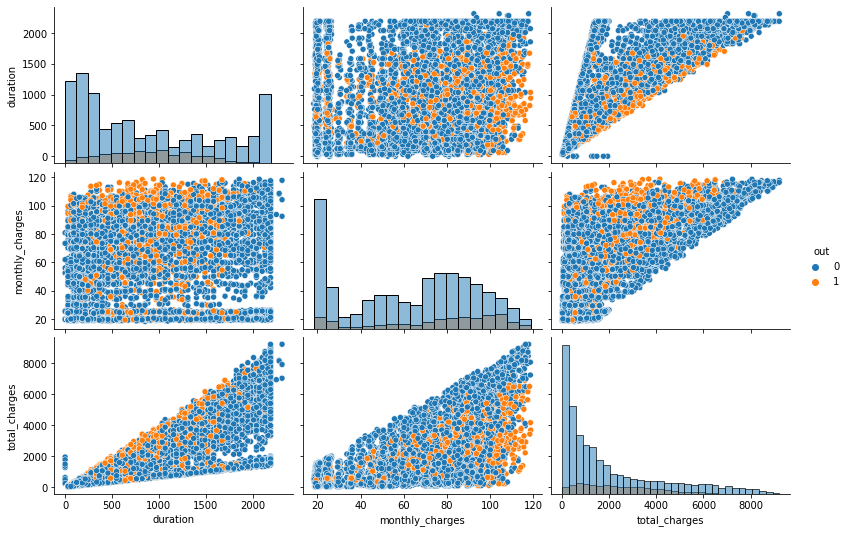

In [49]:
sns.pairplot(big_df, vars = ['duration', 'monthly_charges', 'total_charges'],
                      hue = 'out', diag_kind = 'hist', aspect = 1.5)

Парные графики корреляций показывают высокую мультиколлинеарность между признаками `duration` и `total_charges`, а также между `monthly_charges` и `total_charges`.

**Вывод:**

- Целевой признак `out` несбаллансирован, количество ушедших клиентов (положительных ответов) в 5 раз меньше, чем оставшихся.
- У 3 из 4 категориальных признаков присутствует преобладание какого-либо из классов.
- В качестве бизнес-метрики в этой задаче мы будем использовать AUC-ROC, которая не чувствительна к дисбалансу классов.
- Матрица показывает, что у признака `duration` имеется высокая корреляция с признаками `total_charges` (0.82) и `begin_date` (0.98), у признака `monthly_charges` с `streaming_tv` (0.83), `streaming_movies` (0.84) и `internet_service` (0.92). Корреляция между признаками `end_date` и `out` равна '1'.
- Парные графики корреляций показывают высокую мультиколлинеарность между признаками `duration` и `total_charges`, а также между `monthly_charges` и `total_charges`.

**2.10. Удаление мультиколлинеарных признаков**

По практике при корреляции > 0.8 один из признаков можно удалить без потери качества модели.

Мультиколлинеарные признаки можно удалять для линейных моделей.

В логистической регрессии от sklearn заложена регуляризация, поэтому для нее мультиколлинеарность не страшна, как и для моделей деревьев и бустинговых моделей. Мультиколлинеарность может повлиять на важность признаков, и, как следствие - интерпретируемость модели. Поэтому решение об удалении зависит от поставленной задачи.

В целом, если удаление признака не приведет к явному ухудшению модели, то его можно удалить.

Удалим признаки, у которых имеется высокая корреляция с `duration`:
- `begin_date`
- `total_charges`

с `monthly_charges`:
- `streaming_tv`
- `streaming_movies`
- `internet_service`

с `out`:
- `end_date`.

In [50]:
print('Было:', big_df.shape)
big_df = big_df.drop(['begin_date', 'end_date', 'total_charges', 'streaming_tv',
                      'streaming_movies', 'internet_service'], axis = 1)
print('Стало:', big_df.shape)

Было: (7043, 21)
Стало: (7043, 15)


Построим phi_k-корреляцию для всех признаков после удаления признаков:

interval columns not set, guessing: ['paperless_billing', 'monthly_charges', 'senior_citizen', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'multiple_lines', 'out', 'duration']


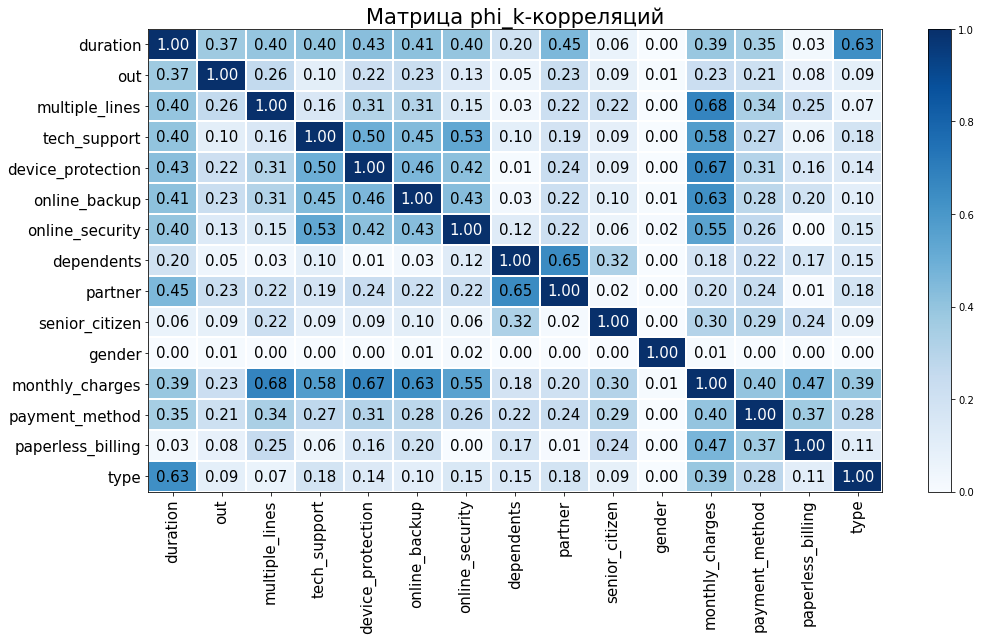

In [51]:
corr_matrix = big_df.phik_matrix()
plot_correlation_matrix(corr_matrix.values, 
                        x_labels = corr_matrix.columns, 
                        y_labels = corr_matrix.index, 
                        vmin = 0, vmax = 1, color_map = 'Blues', 
                        title = 'Матрица phi_k-корреляций',
                        fontsize_factor = 1.5, 
                        figsize = (15, 9))
plt.tight_layout()
plt.show()

Мультиколлинеарность признаков устранена.

In [52]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   int64  
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   gender             7043 non-null   object 
 5   senior_citizen     7043 non-null   int64  
 6   partner            7043 non-null   int64  
 7   dependents         7043 non-null   int64  
 8   online_security    7043 non-null   int64  
 9   online_backup      7043 non-null   int64  
 10  device_protection  7043 non-null   int64  
 11  tech_support       7043 non-null   int64  
 12  multiple_lines     7043 non-null   int64  
 13  out                7043 non-null   int64  
 14  duration           7043 non-null   float64
dtypes: float64(2), int64(10), object(3)
memory usage: 1.1+ MB


В датасете остались численные признаки - `monthly_charge` и `duration`, тип object - `type`, `payment_method`, `gender`, остальные - int.

**Вывод:**

В разделе было выполнено:

- Выбороки объединены.
- Добавлены новые и удалены лишние признаки.
- Признаки переименованы.
- Типы данных признаков изменены.
- Пропуски заполнены.
- Исследованы численные признаки.
- Исследованы категориальные признаки.
- Удалены мультиколлинеарные признаки.

Было выявлено следующее:

- На графиках видно, что оператор связи обоснованно поставил цель удержания клиентов, т к с 2019 года наблюдается отток клиентов.
- В результате исследовательского анализа был выявлен дисбаланс классов у большинства категориальных признаков.
- В качестве основной метрики мы будем использовать AUC-ROC, которая не чувствительна к дисбалансу классов.
- В результате исследовательского анализа было выявлено наличие мультиколлинеарных признаков, 6 из которых, после рассмотрения, было решено удалить.

<a id=3></a>
[Содержание](#0)
## 3. Анализ данных и подготовка признаков

Подготовим наборы данных для обучения следующих моделей:
- LogisticRegression
- RandomForestClassifier
- ExtraTreesClassifier
- LGBMClassifier
- CatBoostClassifier

**Разделение данных на выборки**

Выделим из датасета целевой признак df_y и оставшиеся признаки df_x.

In [53]:
df_x = big_df.drop('out', axis = 1)
df_y = big_df['out']

In [54]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, train_size = 0.75, random_state = RND_STATE)

print('Размер тренерующей выборки:', x_train.shape)
print('Размер тестовой выборки:', x_test.shape)

Размер тренерующей выборки: (5282, 14)
Размер тестовой выборки: (1761, 14)


Удалим индексы для последующего кодирования.

In [55]:
x_train = x_train.reset_index(drop = True)
x_test = x_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

**Кодирование категориальных признаков**

Модели логистической регрессии LogisticRegression, случайного леса RandomForestClassifier, лишних деревьев ExtraTreesClassifier и градиентного бустинга LGBMClassifier не работают с типом данных `object`, поэтому для их применения необходимо преобразовать категориальные признаки в числа.

Посмотрим, какие категориальные признаки нужно преобразовать в числа.

В переменной cat_2 сохраним список всех категориальных признаков, кроме целевого `out`.

<div class="alert alert-warning">
<b>🤔 Рекомендация:</b> Категориальные признаки нельзя преобразовать в численные, их можно закодировать, но они все равно остаются категориальными
</div>

<div class="alert alert-block alert-info">
<b>Fixed!</b>
</div>

In [56]:
cat_2 = list(big_df.loc[:, big_df.dtypes == 'object'].columns.values)\
    + list(big_df.loc[:, big_df.dtypes == 'int'].columns.values)
cat_2 = cat_2[:12]
cat_2

['type',
 'payment_method',
 'gender',
 'paperless_billing',
 'senior_citizen',
 'partner',
 'dependents',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'multiple_lines']

<div class="alert alert-warning">
 <b>🤔 Рекомендация:</b> Сейчас так совпало, что целыми числами у тебя закодированы категориальные столбцы, а численные float64, но в другой ситуации численные тоже могут быть целочисленными, обращай на это внимание
 </div>

Cоздадим копии выборок для последующего кодирования категориальных признаков

In [57]:
x_train_ohe = x_train.copy()
x_test_ohe = x_test.copy()

Cоздадим объект класса OneHotEncoder() и применим функцию fit_transform() для обучающей выборки

In [58]:
encoder = OneHotEncoder(sparse = False, handle_unknown = 'error', drop = 'first')
encoded_x_train = pd.DataFrame(encoder.fit_transform(x_train_ohe[cat_2]))

Добавим названия признаков

In [59]:
encoded_x_train.columns = encoder.get_feature_names()

Присоединим encoded_x_train к исходному датафрейму, удалив признаки из cat_2

In [60]:
x_train_ohe = x_train_ohe.join(encoded_x_train)
x_train_ohe.drop(cat_2, axis = 1, inplace = True)

Применим функцию transform() к тестовой выборке

In [61]:
encoded_test = pd.DataFrame(encoder.transform(x_test_ohe[cat_2]))
encoded_test.columns = encoder.get_feature_names()

Присоединим датафрейм encoded_test к исходному датафрейму, удалив cat_2

In [62]:
x_test_ohe = x_test_ohe.join(encoded_test)
x_test_ohe.drop(cat_2, axis = 1, inplace = True)

print('Размер тренерующей выборки:', x_train_ohe.shape)
display(x_train_ohe.head())
print('Размер тестовой выборки:', x_test_ohe.shape)
display(x_test_ohe.head())

Размер тренерующей выборки: (5282, 17)


,monthly_charges,duration,x0_One year,x0_Two year,x1_Credit card (automatic),x1_Electronic check,x1_Mailed check,x2_Male,x3_1,x4_1,x5_1,x6_1,x7_1,x8_1,x9_1,x10_1,x11_1
0,91.55,1979.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,20.55,1857.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,74.45,488.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,69.15,92.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
4,88.10,1857.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Размер тестовой выборки: (1761, 17)


,monthly_charges,duration,x0_One year,x0_Two year,x1_Credit card (automatic),x1_Electronic check,x1_Mailed check,x2_Male,x3_1,x4_1,x5_1,x6_1,x7_1,x8_1,x9_1,x10_1,x11_1
0,89.85,1767.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
1,59.90,853.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,94.20,337.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,67.75,153.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20.15,31.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


**Масштабирование численных признаков**

Масштабируем численные признаки для моделей логистической регрессии LogisticRegression, случайного леса RandomForestClassifier, лишних деревьев ExtraTreesClassifier и градиентного бустинга LGBMClassifier, используя данные с кодированными категориальными признаками. Для этого стандартизируем данные с помощью класса StandardScaler().

В переменной num_2 сохраним список всех численных признаков, оставшихся после кодирования категориальных признаков.

In [63]:
x_train_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   monthly_charges             5282 non-null   float64
 1   duration                    5282 non-null   float64
 2   x0_One year                 5282 non-null   float64
 3   x0_Two year                 5282 non-null   float64
 4   x1_Credit card (automatic)  5282 non-null   float64
 5   x1_Electronic check         5282 non-null   float64
 6   x1_Mailed check             5282 non-null   float64
 7   x2_Male                     5282 non-null   float64
 8   x3_1                        5282 non-null   float64
 9   x4_1                        5282 non-null   float64
 10  x5_1                        5282 non-null   float64
 11  x6_1                        5282 non-null   float64
 12  x7_1                        5282 non-null   float64
 13  x8_1                        5282 

In [64]:
num_2 = ['monthly_charges', 'duration']
num_2

['monthly_charges', 'duration']

<div class="alert alert-danger">
<s><b>😔 Необходимо исправить:</b> У тебя здесь есть категориальные признаки, их не нужно масштабировать (во всей работе нужно еще раз проверить и правильно разделить численные и категориальные признаки)</s>
</div>

<div class="alert alert-danger">
<s><b>😔 Необходимо исправить V2:</b> У тебя все признаки попали в численные, ты же выше правильно выделил численные, когда смотрел корреляцию, у тебя остались только 'monthly_charges', 'duration'</s>
</div>

<div class="alert alert-block alert-info">
<b>Fixed!</b>
</div>

 <div class="alert alert-success">
 <b>👍 Успех:</b> Все верно!
 </div>

Cоздадим копии выборок для последующего масштабирования численных признаков

In [65]:
x_train_ohe_scaler = x_train_ohe.copy()
x_test_ohe_scaler = x_test_ohe.copy()

Создадим объект класса StandardScaler() и настроим объект на обучающей выборке

In [66]:
scaler = StandardScaler()
scaler.fit(x_train_ohe_scaler[num_2])

StandardScaler()

Преобразуем обучающую и тестовую выборки функцией transform()

In [67]:
x_train_ohe_scaler[num_2] = scaler.transform(x_train_ohe_scaler[num_2])
x_test_ohe_scaler[num_2] = scaler.transform(x_test_ohe_scaler[num_2])

print('Размер тренерующей выборки:', x_train_ohe_scaler.shape)
display(x_train_ohe_scaler.head())
print('Размер тестовой выборки:', x_test_ohe_scaler.shape)
display(x_test_ohe_scaler.head())

Размер тренерующей выборки: (5282, 17)


,monthly_charges,duration,x0_One year,x0_Two year,x1_Credit card (automatic),x1_Electronic check,x1_Mailed check,x2_Male,x3_1,x4_1,x5_1,x6_1,x7_1,x8_1,x9_1,x10_1,x11_1
0,0.891414,1.569091,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,-1.469492,1.390794,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.322801,-0.609929,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.146565,-1.188663,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
4,0.776694,1.390794,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Размер тестовой выборки: (1761, 17)


,monthly_charges,duration,x0_One year,x0_Two year,x1_Credit card (automatic),x1_Electronic check,x1_Mailed check,x2_Male,x3_1,x4_1,x5_1,x6_1,x7_1,x8_1,x9_1,x10_1,x11_1
0,0.834885,1.259264,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
1,-0.161018,-0.076500,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.979532,-0.830608,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,0.100012,-1.099514,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.482793,-1.277811,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


**Масштабирование численных признаков для модели CatBoostClassifier**

Отдельно масштабируем численные признаки для модели градиентного бустинга CatBoostClassifier, используя данные с некодированными категориальными признаками.

CatBoost применяет различные техники кодирования категориальных признаков и дополнительное преобразование категориальных признаков в числа здесь не нужно.

В переменной num_2 список всех численных признаков

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

In [68]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               5282 non-null   object 
 1   paperless_billing  5282 non-null   int64  
 2   payment_method     5282 non-null   object 
 3   monthly_charges    5282 non-null   float64
 4   gender             5282 non-null   object 
 5   senior_citizen     5282 non-null   int64  
 6   partner            5282 non-null   int64  
 7   dependents         5282 non-null   int64  
 8   online_security    5282 non-null   int64  
 9   online_backup      5282 non-null   int64  
 10  device_protection  5282 non-null   int64  
 11  tech_support       5282 non-null   int64  
 12  multiple_lines     5282 non-null   int64  
 13  duration           5282 non-null   float64
dtypes: float64(2), int64(9), object(3)
memory usage: 577.8+ KB


Cоздадим копии выборок для последующего масштабирования численных признаков

In [69]:
x_train_scaler = x_train.copy()
x_test_scaler = x_test.copy()

Создадим объект класса StandardScaler() и настроим объект на обучающей выборке

In [70]:
scaler = StandardScaler()
scaler.fit(x_train_scaler[num_2])

StandardScaler()

Преобразуем обучающую и тестовую выборки функцией transform()

In [71]:
x_train_scaler[num_2] = scaler.transform(x_train_scaler[num_2])
x_test_scaler[num_2] = scaler.transform(x_test_scaler[num_2])

print('Размер тренерующей выборки:', x_train_scaler.shape)
display(x_train_scaler.head())
print('Размер тестовой выборки:', x_test_scaler.shape)
display(x_test_scaler.head())

Размер тренерующей выборки: (5282, 14)


,type,paperless_billing,payment_method,monthly_charges,gender,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,multiple_lines,duration
0,Two year,0,Bank transfer (automatic),0.891414,Female,0,1,1,1,1,1,1,1,1.569091
1,Two year,0,Credit card (automatic),-1.469492,Male,0,1,1,0,0,0,0,0,1.390794
2,Month-to-month,1,Bank transfer (automatic),0.322801,Male,1,0,0,0,0,0,0,1,-0.609929
3,Month-to-month,1,Bank transfer (automatic),0.146565,Female,0,1,1,0,1,1,0,1,-1.188663
4,Two year,0,Mailed check,0.776694,Female,0,1,1,1,1,1,1,1,1.390794


Размер тестовой выборки: (1761, 14)


,type,paperless_billing,payment_method,monthly_charges,gender,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,multiple_lines,duration
0,One year,1,Bank transfer (automatic),0.834885,Male,1,1,1,1,1,0,1,1,1.259264
1,One year,1,Electronic check,-0.161018,Female,0,0,0,1,1,0,1,0,-0.076500
2,Month-to-month,1,Electronic check,0.979532,Female,0,0,0,0,1,1,1,0,-0.830608
3,Month-to-month,1,Electronic check,0.100012,Male,0,0,0,0,0,0,0,0,-1.099514
4,Month-to-month,1,Bank transfer (automatic),-1.482793,Male,0,1,1,0,0,0,0,0,-1.277811


In [72]:
x_train_scaler.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               5282 non-null   object 
 1   paperless_billing  5282 non-null   int64  
 2   payment_method     5282 non-null   object 
 3   monthly_charges    5282 non-null   float64
 4   gender             5282 non-null   object 
 5   senior_citizen     5282 non-null   int64  
 6   partner            5282 non-null   int64  
 7   dependents         5282 non-null   int64  
 8   online_security    5282 non-null   int64  
 9   online_backup      5282 non-null   int64  
 10  device_protection  5282 non-null   int64  
 11  tech_support       5282 non-null   int64  
 12  multiple_lines     5282 non-null   int64  
 13  duration           5282 non-null   float64
dtypes: float64(2), int64(9), object(3)
memory usage: 577.8+ KB


 <div class="alert alert-success">
 <b>👍 Успех:</b> Все верно!
 </div>

**Вывод:**

В разделе было выполнено следующее:

- Данные разделены на обучающую и тестовую выборки.
- Выполнено кодирование категориальных признаков с помощью техники прямого кодирования One-Hot Encoding (OHE).
- Выполнено масштабирование численных признаков для разных моделей.

 <div class="alert alert-success">
 <b>👍 Успех:</b> Данные подготовлены для обучения и тестирования моделей
 </div>

<a id=4></a>
[Содержание](#0)
## 4. Обучение моделей

Обучим следующие модели:
- Логистическую регрессию (LogisticRegression)
- Случайный лес (RandomForest)
- Лишних деревьев (ExtraTreesClassifier)
- Градиентный бустинг LightGBM
- Градиентный бустинг CatBoost
для задачи классификации.

Для обучения логистической регрессии используем Pipeline, для остальных моделей применим поиск гиперпараметров с помощью GridSearchCV.

Используем разделение на фолды с помощью KFold. Зададим параметры для кроссвалидации: n_splits - количество фолдов.

In [73]:
kf = KFold(n_splits = 5, random_state = RND_STATE, shuffle = True)

Сохраним результаты в таблицу scores_data:

In [74]:
scores_data = []

Напишем функцию fit_model(), которая для моделей RandomForest, ExtraTreesClassifier, LightGBM и CatBoost подбирает лучшие параметры с помощью функции GridSearchCV, а также выводит на экран и сохраняет в итоговую таблицу метрики:
- AUC-ROC (целевая метрика)
- accuracy (дополнительная метрика)
- fit_time (время обучения)
- score_time (время принятия решения)

In [75]:
def fit_model(estimator, param_grid, x_train, y_train):
    model = GridSearchCV(estimator = estimator,
                         param_grid = param_grid,
                         n_jobs = -1,
                         cv = kf,
                         scoring = ['roc_auc', 'accuracy'],
                         refit = 'roc_auc'
                        )

    model.fit(x_train, y_train)
    
    res = pd.DataFrame(model.cv_results_).iloc[model.best_index_]
#    print(res)
    
    roc_auc = round(model.best_score_, 5)
    accuracy = round(res['mean_test_accuracy'], 5)   
    fit_time = round(res['mean_fit_time'], 3)
    score_time = round(res['mean_score_time'], 3)

    print()
    print('Лучшее значение AUC-ROC:', roc_auc)
    print('Лучшее значение Accuracy:', accuracy)
    print('Время обучения модели:', fit_time, 's')
    print('Время предсказания модели:', score_time, 's')
    print("Лучший набор параметров:", model.best_params_)
    print()

    scores_data.append([estimator, roc_auc, accuracy, fit_time, score_time])

    return model.best_estimator_, model.best_score_

**4.1. LogisticRegression** - логистическая регрессия

Классифицируем обучающие данные с помощью модели логистической регрессии LogisticRegression.

Используем Pipeline для автоматизации предварительных преобразований данных перед обучением модели:

In [76]:
%%time

lr_estimator = Pipeline([
    ('lr', LogisticRegression(random_state = RND_STATE, 
                              solver = 'lbfgs', 
                              max_iter = 1000))
])

scores = cross_validate(lr_estimator, 
                        x_train_ohe_scaler, 
                        y_train,
                        scoring = ['roc_auc', 'accuracy'], 
                        cv = kf, 
                        return_train_score = True)

roc_auc_lr = round(scores['test_roc_auc'].mean(), 5)
accuracy_lr = round(scores['test_accuracy'].mean(), 5)

print('Лучшее значение AUC-ROC:', roc_auc_lr)
print('Лучшее значение accuracy:', accuracy_lr)

Лучшее значение AUC-ROC: 0.74873
Лучшее значение accuracy: 0.85934
CPU times: user 931 ms, sys: 2.84 s, total: 3.77 s
Wall time: 3.68 s


In [77]:
scores_data.append(['LogisticRegression', roc_auc_lr, accuracy_lr, 1.5, 0.1])

**4.2. RandomForestClassifier** - модель случайного леса

In [78]:
%%time

rf_param_grid = {
    'max_depth': range(5, 12, 1),
    'n_estimators': range(50, 101, 5),
}

rf_best_model = fit_model(
    estimator = RandomForestClassifier(),
    param_grid = rf_param_grid,
    x_train = x_train_ohe_scaler,
    y_train = y_train
)


Лучшее значение AUC-ROC: 0.82765
Лучшее значение Accuracy: 0.85593
Время обучения модели: 0.295 s
Время предсказания модели: 0.074 s
Лучший набор параметров: {'max_depth': 8, 'n_estimators': 100}

CPU times: user 1min 35s, sys: 542 ms, total: 1min 36s
Wall time: 1min 36s


**4.3. ExtraTreesClassifier** - модель лишних деревьев

In [79]:
%%time

rf_param_grid = {
    'max_depth': range(2, 21, 1),
    'n_estimators': range(50, 351, 25),
}

rf_best_model = fit_model(
    estimator = ExtraTreesClassifier(),
    param_grid = rf_param_grid,
    x_train = x_train_ohe_scaler,
    y_train = y_train
)


Лучшее значение AUC-ROC: 0.79578
Лучшее значение Accuracy: 0.84873
Время обучения модели: 0.21 s
Время предсказания модели: 0.047 s
Лучший набор параметров: {'max_depth': 8, 'n_estimators': 100}

CPU times: user 12min 18s, sys: 3.31 s, total: 12min 21s
Wall time: 12min 24s


**4.4. LGBMClassifier** - модель градиентного бустинга

Подадим на вход LGBMClassifier признаки x_train_ohe_scaler (с OHE), т к модель LGBMClassifier не распознаёт тип данных object:

In [80]:
%%time

lgbm_param_grid = {
    'learning_rate': [0.1],
    'max_depth': range(5, 9, 2),
    'n_estimators': [100, 200],
}

lgbm_best_model = fit_model(
    estimator = LGBMClassifier(n_jobs = -1),
    param_grid = lgbm_param_grid,
    x_train = x_train_ohe_scaler,
    y_train = y_train
)


Лучшее значение AUC-ROC: 0.88996
Лучшее значение Accuracy: 0.89606
Время обучения модели: 79.254 s
Время предсказания модели: 0.167 s
Лучший набор параметров: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}

CPU times: user 30min 39s, sys: 27.3 s, total: 31min 6s
Wall time: 31min 16s


**4.5. CatBoostClassifier** - модель градиентного бустинга

CatBoost применяет различные техники кодирования категориальных признаков, по этому дополнительное преобразование категориальных признаков в числа здесь не нужно. Обучим CatBoostClassifier на наборе признаков x_train_scaler (без OHE).

В качестве списка категориальных признаков укажем переменную cat_2.

CatBoostClassifier создает временные файлы для обучения. Чтобы не появлялась ошибка о том, что по указанными путям у CatBoostClassifier нет доступа к созданию файлов, укажем в модели параметр allow_writing_files = False.

Для вычисления метрик AUC-ROC и accuracy подадим на вход модели catboost_best_model признаки x_train_scaler (без OHE).

In [81]:
%%time

catboost_param_grid = {
    'depth': range(3, 10, 1),
    'iterations': range(100, 351, 50),
    'learning_rate': [0.15],
}
catboost_best_model = fit_model(
    estimator = CatBoostClassifier(verbose = False, 
                                 allow_writing_files = False,
                                 cat_features = cat_2),
    param_grid = catboost_param_grid,
    x_train = x_train_scaler,
    y_train = y_train,
)


Лучшее значение AUC-ROC: 0.92038
Лучшее значение Accuracy: 0.91594
Время обучения модели: 1.134 s
Время предсказания модели: 0.01 s
Лучший набор параметров: {'depth': 4, 'iterations': 350, 'learning_rate': 0.15}

CPU times: user 4min 4s, sys: 9.14 s, total: 4min 13s
Wall time: 4min 13s


In [82]:
result = pd.DataFrame(scores_data)
result.columns = ['Model', 'AUC-ROC', 'Accuracy','Fit_time', 'Score_time']
result.set_index('AUC-ROC', inplace = True)
display(result.sort_values('AUC-ROC', ascending = False))

,Model,Accuracy,Fit_time,Score_time
AUC-ROC,,,,
0.92038,<catboost.core.CatBoostClassifier object at 0x...,0.91594,1.134,0.010
0.88996,LGBMClassifier(),0.89606,79.254,0.167
0.82765,RandomForestClassifier(),0.85593,0.295,0.074
0.79578,ExtraTreesClassifier(),0.84873,0.210,0.047
0.74873,LogisticRegression,0.85934,1.500,0.100


**Вывод:**

В разделе было выполнено следующее:

- Написана функция fit_model() для обучения моделей и вычисления метрик AUC-ROC и accuracy, а так же времени обучения и времени принятия решения с использованием GridSearchCV.
- Обучены 5 моделей: LogisticRegression, RandomForestClassifier, ExtraTreesClassifier, LGBMClassifier и CatBoostClassifier.
- Подобраны оптимальные гиперпараметры для моделей.

Было выявлено следующее:

В качестве лучшей выбрана модель *CatBoostClassifier*, так как на обучающей выборке она имеет следующие значения метрик оценки качества:
- AUC-ROC = 0.92
- Accuracy = 0.916

при следующих параметрах:

- Глубина дерева: depth = 4
- Количество итераций: iterations = 350
- Коэффициент скорости обучения (размер шага градиентного спуска): learning_rate = 0.15

<a id=5></a>
[Содержание](#0)
## 5. Тестирование лучшей модели

Проверим на тестовой выборке качество выбранной модели CatBoostClassifier:

In [98]:
%%time

model = CatBoostClassifier(iterations = 350,
                           learning_rate = 0.15,
                           depth = 4,
                           cat_features = cat_2,
                           verbose = False,
                           allow_writing_files = False,
                           random_state = RND_STATE) 

model.fit(x_train_scaler, y_train)

CPU times: user 1.31 s, sys: 20 ms, total: 1.33 s
Wall time: 1.34 s


**5.1. AUC-ROC**

Найдём значения вероятностей классов.

В переменную probabilities_1 сохраним значения вероятностей класса '1' и рассчитаем AUC-ROC:

In [99]:
probabilities = model.predict_proba(x_test_scaler)
probabilities_1 = probabilities[:, 1]
roc_auc_test = round(roc_auc_score(y_test, probabilities_1), 5)
print('Значение AUC-ROC на тестовых данных:', roc_auc_test)

Значение AUC-ROC на тестовых данных: 0.92645


**5.2. Accuracy**

Получим предсказания модели на тестовой выборке и рассчитаем Accuracy:

In [100]:
predictions = model.predict(x_test_scaler)
accuracy_test = round(accuracy_score(y_test, predictions), 5)

print('Значение Accuracy на тестовых данных:', accuracy_test)

Значение Accuracy на тестовых данных: 0.92391


**Вывод:**

В результате тестирования лучшей модели градиентного бустинга CatBoostClassifier на тестовых данных были получены следующие значения целевых метрик:
- Значение AUC-ROC на тестовых данных: 0.92645
- Значение Accuracy на тестовых данных: 0.92391
- Время обучения модели: 1.34 s
- Время предсказания модели: 0.004 s

Это соответствует условию задачи AUC-ROC > 0.85	

**5.3. Важность признаков**

Определим важность признаков для модели CatBoostClassifier.

Получим список с названиями признаков и массив с их важностью и отобразим ее на графике:

In [86]:
priznaki = catboost_best_model[0].feature_names_
importances = catboost_best_model[0].feature_importances_
sorted_idx = importances.argsort()[::1]

Построим график важности признаков:

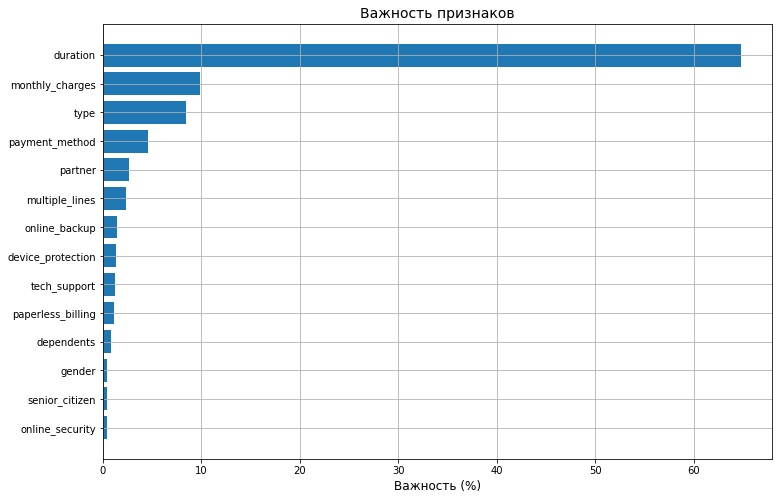

In [87]:
plt.figure(figsize = (12, 8))
plt.barh(priznaki, importances[sorted_idx])
plt.yticks(range(len(priznaki)), np.array(priznaki)[sorted_idx])
plt.grid(True)
plt.title('Важность признаков', fontsize = 14)
plt.xlabel('Важность (%)', fontsize = 12)
plt.show()

На графике видно, что основе влияние на результат модели модели оказывают 4 признака:
- duration
- monthly_charhes
- type
- payment_methode

**5.4. Матрица ошибок**

Рассмотрим матрицу ошибок:

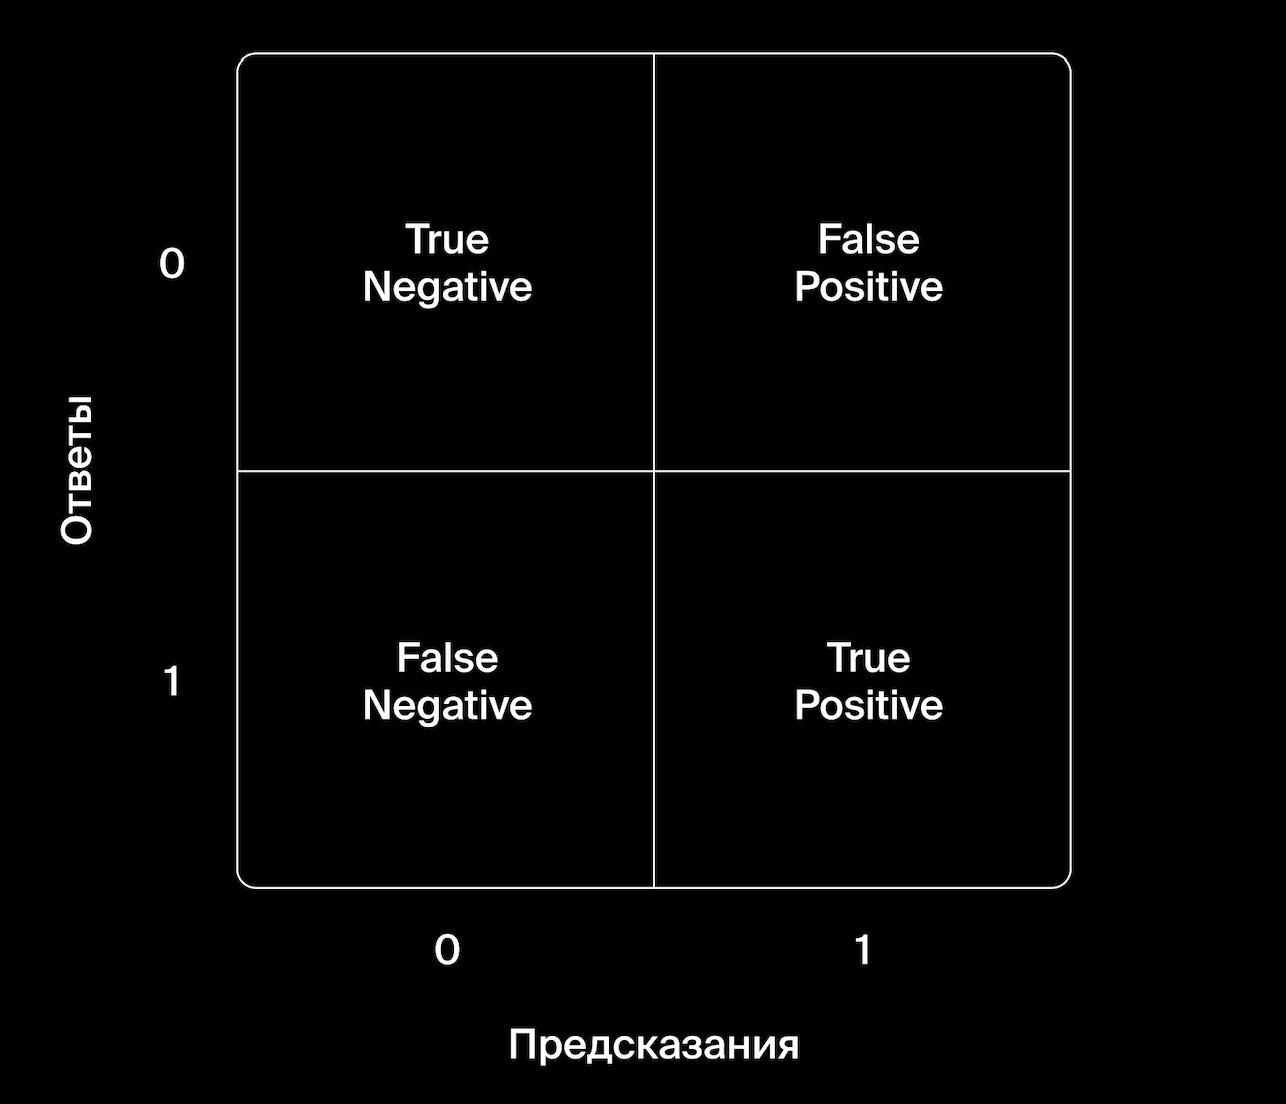

, где

- True Positive, TP - истинно положительные ответы в правом нижнем углу матрицы
- False Positive, FP - ложноположительные ответы в правом верхнем углу
- True Negative, TN - истинно отрицательные ответы в левом верхнем углу
- False Negative, FN - ложноотрицательные ответы в левом нижнем углу
- P = TP + FN - общее количество положительных ответов (объекты класса "1")
- N = FP + TN - общее количество отрицательных ответов (объекты класса "0")

Рассчитаем матрицу ошибок для тестовой выборки.

Посмотрим баланс классов целевого признака:

In [88]:
y_test.value_counts()

0    1491
1     270
Name: out, dtype: int64

Построим матрицу ошибок:

In [89]:
matrix = confusion_matrix(y_test, catboost_best_model[0].predict(x_test_scaler))

Построим тепловую карту (хитмэп) матрицы ошибок:

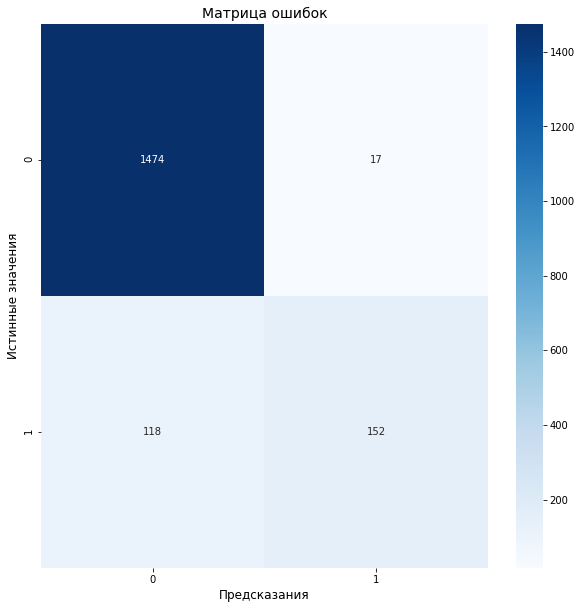

In [90]:
plt.figure(figsize = (10, 10))
sns.heatmap(matrix, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Матрица ошибок', fontsize = 14)
plt.xlabel('Предсказания', fontsize = 12)
plt.ylabel('Истинные значения', fontsize = 12)
plt.show()

По матрице ошибок нам необходимо определить:

- долю ложноположительных ответов, FP / N (оператор предложил промокоды клиентам, которые не планировали уходить)
- долю ложноотрицательных ответов, FN / P (оператор не предложил промокоды клиентам, которые ушли)

Для расчёта значений воспользуемся формулами:

FP / N = (FP / (FP + TN))

FN / P = (FN / (TP + FN)

In [91]:
matrix = confusion_matrix(y_test, catboost_best_model[0].predict(x_test_scaler))
matrix

array([[1474,   17],
       [ 118,  152]])

Доля ложноположительных ответов FP / N на тестовой выборке:

In [92]:
fp_neg = (matrix[0][1] / (matrix[0][1] + matrix[0][0]))
print(f'{fp_neg:.2%}')

1.14%


Доля ложноотрицательных ответов FN / P на тестовой выборке:

In [93]:
fn_pos = (matrix[1][0] / (matrix[1][1] + matrix[1][0]))
print(f'{fn_pos:.2%}')

43.70%


На тестовой выборке доля ложноотрицательных ответов (42.96%) значительно превышает долю ложноположительных (1.61%), следовательно модель лучше прогнозирует объекты отрицательного класса (клиенты остались), что является следствием дисбаланса классов в целевом признаке.

**5.5. ROC-кривая**

Построим ROC-кривую, или кривую ошибок (от англ. receiver operating characteristic, «характеристика работы приёмника») для модели CatBoostClassifier на тестовой выборке. 

Для построения ROC-кривой необходимо на графике отобразить:
- По горизонтали характеристику FPR = FP / FP + TN
- По вертикали TPR = TP / TP + FN

, где

- TPR (True Positive Rate) - доля верно предсказанных объектов к общему числу объектов класса (recall, "полнота")
- FPR (False Positive Rate) - доля ложных срабатываний к общему числу объектов за пределами класса

Для сравнения наложим на график ROC-кривую для модели, которая всегда отвечает случайно. Она выглядит как прямая, идущая из левого нижнего угла в верхний правый. Чем график выше, тем больше значение TPR и лучше качество модели:

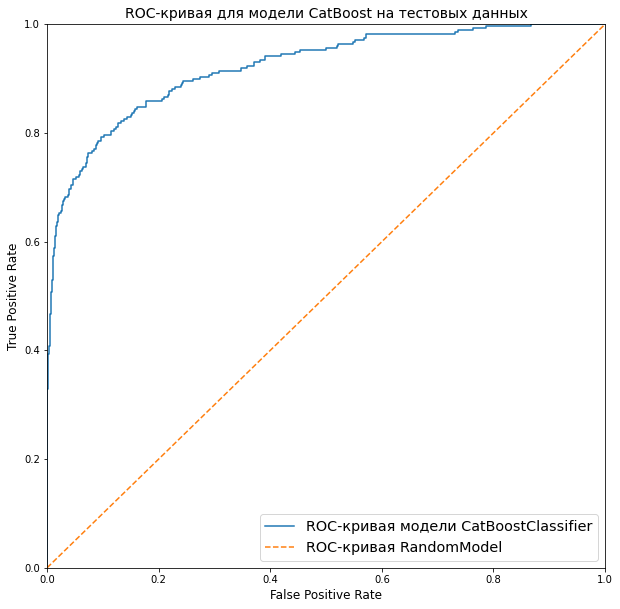

In [94]:
fpr_test, tpr_test, thresholds = roc_curve(y_test, probabilities_1)
plt.figure(figsize = (10, 10))
plt.plot(fpr_test, tpr_test, label = 'ROC-кривая модели CatBoostClassifier')

plt.plot([0, 1], [0, 1], linestyle = '--', label = 'ROC-кривая RandomModel')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.legend(loc = 'lower right', fontsize = 'x-large')

plt.xlabel('False Positive Rate', fontsize = 12)
plt.ylabel('True Positive Rate', fontsize = 12)
plt.title('ROC-кривая для модели CatBoost на тестовых данных', fontsize = 14)

plt.show()

Площадь под ROC-кривой модели градиентного бустинга CatBoostClassifier AUC-ROC = 0.92, что значительно превышает площадь под ROC-кривой случайной модели AUC-ROC = 0.5

**Вывод:**

Лучшая модель градиентного бустинга CatBoostClassifier на тестовых данных были получены следующие значения целевых метрик:

- Значение AUC-ROC на тестовых данных: 0.926
- Значение Accuracy на тестовых данных: 0.923
- Время обучения модели: 1.34 s
- Время предсказания модели: 0.004 s

Это соответствует условию задачи AUC-ROC > 0.85

На тестовой выборке доля ложноотрицательных ответов (43.7%) значительно превышает долю ложноположительных (1.14%), следовательно модель лучше прогнозирует объекты отрицательного класса (клиенты остались), что является следствием дисбаланса классов в целевом признаке.

Площадь под ROC-кривой модели градиентного бустинга CatBoostClassifier AUC-ROC = 0.926, что значительно превышает площадь под ROC-кривой случайной модели AUC-ROC = 0.5

<a id=6></a>
[Содержание](#0)
## 6. Общий вывод

Проведено исследование с целью построения модели машинного обучения, для прогнозирования оттока клиентов.

Результаты исследования позволят оператору связи выяснить, каким пользователям нужно будет предлагать промокоды и специальные условия.

Входные данные: персональные данные о некоторых клиентах, информация об их тарифах и договорах на 1 февраля 2020 года.

В ходе исследования были обучены модели и получены следующие результаты:

In [95]:
display(result.sort_values('AUC-ROC', ascending = False))

,Model,Accuracy,Fit_time,Score_time
AUC-ROC,,,,
0.92038,<catboost.core.CatBoostClassifier object at 0x...,0.91594,1.134,0.010
0.88996,LGBMClassifier(),0.89606,79.254,0.167
0.82765,RandomForestClassifier(),0.85593,0.295,0.074
0.79578,ExtraTreesClassifier(),0.84873,0.210,0.047
0.74873,LogisticRegression,0.85934,1.500,0.100


Лучшая модель градиентного бустинга CatBoostClassifier на тестовых данных показала следующие значения целевых метрик:

- Значение AUC-ROC на тестовых данных: 0.926
- Значение Accuracy на тестовых данных: 0.923

Целевая метрика соответствует условию задачи AUC-ROC > 0.85

**Общие рекомендации:**

Оператору связи «Ниединогоразрыва.ком» можно рекомендовать использовать полученную модель градиентного бустинга CatBoostClassifier с поправкой на дисбаланс классов в целевом признаке, т к при имеющихся входных данных модель склонна пропускать клиентов, которые планируют уйти.

<a id=7></a>
[Содержание](#0)
## 7. Отчет

### 7.1. Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов.

Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Цель проекта:**

- Провести исследование и подготовить модель машинного обучения, которая поможет прогнозировать отток клиентов.

- Если модель покажет, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

- Значение метрики AUC-ROC должно быть не ниже 0.85.

**Входные данные:**

Оператор предоставил информацию о договорах клиентов по состоянию на 1 февраля 2020.

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

**План работы:**

### 7.2. Исследовательский анализ данных

- Загружаем данные
  * Все четыре таблицы загружаем в датафреймы.
  * Проверяем на отсутствие явных пропусков и дубликатов.
  * Строим гисторгаммы распределения численных переменных.


- Объединяем выбороки
  * В каждой из четырёх датафремов присутствует признак `customerID`, объединеняем выбороки по этому признаку с использованием метода merge().
  * Делаем признак `customerID` индексом.


- Заполнение пропусков
  * Исходные таблицы имели разные размеры, по этому после объединения появились пропуски у клиентов, которые пользуются только одной из услуг (интернет/телефон). Их можно заполнить значением 'No'.
  * Пропуски в признаке `total_charges` заполняем по признакам `monthly_charges` и `type`, помножив ежемесячный платеж на срок договора в месяцах.


- Преобразование типов
  * В признаке `end_date` заменим значение "No" на дату выгрузки данных 2020-02-01.
  * Поля с датами `beg_date` и `end_date` приводим к типу datetime64.
  * Категориальные признаки: `paperless_billing`, `Partner`, `Dependents`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies` и `MultipleLines` принимают только два значения ('No'/'Yes'). Приведем их к типу `int` со значениями '0' и '1'.


- Преобразование признаков
  * Добавим в датасет категориальный целевой признак - `out`, который принимает значения '1' (клиент ушёл) и '0' (клиент остался). За основу возьмем произнак `end_date`, если дата указана, значит клиент ушел, признак out = 1.
  * Для удобства работы с датами добавим в датасет новый признак `duration` - длительность договора в днях и сохраним его в тип int.


- Исследование численных признаков
  * Строим гистограммы и сосмотрим распределение численных признаков.
  * Проверяем на мультиколлинеарность, для численных признаков используем корреляцию Пирсона/Спирмена.


- Исследование категориальных признаков
  * Строим гистограммы и сосмотрим состав категориальных признаков, включая целевой признак.
  * У большинства признаков наблюдается небольшой перекос классов, особенно у у целевого признака out: 84% (действующие клиенты) к 16% (ушедшие).
  * Проверяем на мультиколлинеарность. Строим phi_k-корреляцию для всех признаков - численных и категориальных.


- Удаление мультиколлинеарных признаков
  * При корреляции > 0.8 один из признаков можно удалить без потери качества модели.
  * Удаляем признаки: `begin_date`, `end_date`, `total_charges`, `streaming_tv`, `streaming_movies`, `internet_service`.

*Нужно подтвердить следующее:*

- На графиках видно, что оператор связи обоснованно поставил цель удержания клиентов, т к с 2019 года наблюдается отток клиентов.
- В результате исследовательского анализа был выявлен дисбаланс классов у большинства категориальных признаков.
- В качестве основной метрики мы будем использовать AUC-ROC, которая не чувствительна к дисбалансу классов.
- В результате исследовательского анализа было выявлено наличие мультиколлинеарных признаков, 6 из которых, после рассмотрения, было решено удалить.

### 7.3. Анализ данных и подготовка признаков

- Подготовим наборы данных для обучения моделей
  * Выделим из датасета целевой признак df_y и оставшиеся признаки df_x.
  * Разделим данных на обучающую и тестовую выборки в соотношении 3:1.
  * Удалим индексы для последующего кодирования.


- Кодирование категориальных признаков
  * Модели логистической регрессии LogisticRegression, случайного леса RandomForestClassifier, лишних деревьев ExtraTreesClassifier и градиентного бустинга LGBMClassifier не работают с типом данных `object`, поэтому для их применения преобразуем категориальные признаки в численные.
  * Сохраним список всех категориальных признаков, кроме целевого `out`, в переменной `cat_2`.
  * Cоздадим копии выборок для последующего кодирования категориальных признаков.
  * Cоздадим объект класса OneHotEncoder() и применим функцию fit_transform() к категоиальным признакам из `cat_2` в обучающей и тестовой выборках.


- Масштабирование численных признаков
  * Масштабируем численные признаки для моделей логистической регрессии LogisticRegression, случайного леса RandomForestClassifier, лишних деревьев ExtraTreesClassifier и градиентного бустинга LGBMClassifier, используя данные с кодированными категориальными признаками. Для этого стандартизируем данные с помощью класса StandardScaler().
  * В переменной `num_2` сохраним список всех численных признаков, оставшихся после кодирования категориальных признаков.


- Масштабирование численных признаков для модели CatBoostClassifier
  * Отдельно масштабируем численные признаки для модели градиентного бустинга CatBoostClassifier, используя данные с некодированными категориальными признаками.
  * CatBoost применяет различные техники кодирования категориальных признаков и дополнительное преобразование категориальных признаков в численные здесь не нужно.

### 7.4. Обучение моделей

- Напишем функцию fit_model(), которая для моделей RandomForest, ExtraTreesClassifier, LightGBM и CatBoost подбирает лучшие параметры с помощью функции GridSearchCV, а также выводит на экран и сохраняет в итоговую таблицу метрики:
  * AUC-ROC (целевая метрика)
  * Accuracy (дополнительная метрика)
  * fit_time (время обучения)
  * score_time (время принятия решения)


- Обучим модели
  * Логистическую регрессию (LogisticRegression)
  * Случайный лес (RandomForest)
  * Лишних деревьев (ExtraTreesClassifier)
  * Градиентный бустинг LightGBM
  * Градиентный бустинг CatBoost для задачи классификации.

Результат сведем в таблицу:

In [96]:
display(result.sort_values('AUC-ROC', ascending = False))

,Model,Accuracy,Fit_time,Score_time
AUC-ROC,,,,
0.92038,<catboost.core.CatBoostClassifier object at 0x...,0.91594,1.134,0.010
0.88996,LGBMClassifier(),0.89606,79.254,0.167
0.82765,RandomForestClassifier(),0.85593,0.295,0.074
0.79578,ExtraTreesClassifier(),0.84873,0.210,0.047
0.74873,LogisticRegression,0.85934,1.500,0.100


*Нужно подтвердить следующее:*

В качестве лучшей выбрана модель *CatBoostClassifier*, так как на обучающей выборке она имеет следующие значения метрик оценки качества:
- AUC-ROC = 0.926
- Accuracy = 0.923

при параметрах:

- Глубина дерева: depth = 4
- Количество итераций: iterations = 350
- Коэффициент скорости обучения (размер шага градиентного спуска): learning_rate = 0.15

### 7.5. Тестирование моделей

- Протестируем лучшую модель градиентного бустинга CatBoostClassifier на тестовых данных.
  * При тестировании получены следующие значения метрик: AUC-ROC - 0.926, Accuracy - 0.923
  * Это соответствует условию задачи AUC-ROC > 0.85


- Важность признаков
  * Построим график влияния признаков на результат работы модели
  * 4 признака оказывают основное влияние: `duration` (58%), `monthly_charhes` (12%), `type` (8%), `payment_methode` (5%)


- Матрица ошибок
  * Постоим матрицу ошибок и отразим ее в виде тепловой карты (хитмэп)


- ROC-кривая
  * Построим ROC-кривую (кривую ошибок) для модели CatBoostClassifier на тестовой выборке
  * Нужно проверить следующее:
  * На тестовой выборке доля ложноотрицательных ответов (43.7%) значительно превышает долю ложноположительных (1.14%), следовательно модель лучше прогнозирует объекты отрицательного класса (клиенты остались), что является следствием дисбаланса классов в целевом признаке.
  * Площадь под ROC-кривой модели градиентного бустинга CatBoostClassifier AUC-ROC = 0.926, что значительно превышает площадь под ROC-кривой случайной модели AUC-ROC = 0.5

### 7.6. Общий вывод

Проведено исследование с целью построения модели машинного обучения, для прогнозирования оттока клиентов.

В ходе исследования обучены модели:

In [97]:
display(result.sort_values('AUC-ROC', ascending = False))

,Model,Accuracy,Fit_time,Score_time
AUC-ROC,,,,
0.92038,<catboost.core.CatBoostClassifier object at 0x...,0.91594,1.134,0.010
0.88996,LGBMClassifier(),0.89606,79.254,0.167
0.82765,RandomForestClassifier(),0.85593,0.295,0.074
0.79578,ExtraTreesClassifier(),0.84873,0.210,0.047
0.74873,LogisticRegression,0.85934,1.500,0.100


Лучшая модель градиентного бустинга CatBoostClassifier на тестовых данных показала следующие значения целевых метрик:

- Значение AUC-ROC на тестовых данных: 0.926
- Значение Accuracy на тестовых данных: 0.923

Целевая метрика соответствует условию задачи AUC-ROC > 0.85

**Общие рекомендации:**

Оператору связи «Ниединогоразрыва.ком» можно рекомендовать использовать полученную модель градиентного бустинга CatBoostClassifier с поправкой на дисбаланс классов в целевом признаке, т к при имеющихся входных данных модель склонна пропускать клиентов, которые планируют уйти.

### 7.7. Трудности

Основные трудности возникли с выбором типа данных для основной части категороиальных признаков. В первом варианте эти признаки были приведены к типу Bool, но модель CatBoostClassifier не считала целевую метрику ROC-AUC. Было принято решение привести категороиальные признаки к типу int.